In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path('./') / 'data'
train = pd.read_csv(data_path / "train.csv")
client = pd.read_csv(data_path / "client.csv")
historical_weather = pd.read_csv(data_path / "historical_weather.csv")
forecast_weather = pd.read_csv(data_path / "forecast_weather.csv")
electricity = pd.read_csv(data_path / "electricity_prices.csv")
gas = pd.read_csv(data_path / "gas_prices.csv")

location = (pd.read_csv(data_path / "county_lon_lats.csv")
            .drop(columns=["Unnamed: 0"])
           )


In [6]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df
    
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [7]:
# Generate features for training data
# NOTE: this can take a little bit to run
FeatureProcessor = FeatureProcessorClass()
N_day_lags = 15  # incorporate data from historical 15 days


data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(data.copy(), 
                                  N_day_lags = N_day_lags)

In [8]:
# Save features to CSV
df.to_csv('train_features.csv', index = False)

In [9]:

df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date',
       'year', 'quarter', 'month', 'week', 'hour', 'day_of_year',
       'day_of_month', 'day_of_week', 'eic_count_client',
       'installed_capacity_client', 'date_client', 'temperature_h_mean',
       'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean',
       'surface_pressure_h_mean', 'cloudcover_total_h_mean',
       'cloudcover_low_h_mean', 'cloudcover_mid_h_mean',
       'cloudcover_high_h_mean', 'windspeed_10m_h_mean',
       'winddirection_10m_h_mean', 'shortwave_radiation_h_mean',
       'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h',
       'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean',
       'cloudcover_high_f_mean', 'cloudcover_low_f_mean',
       'cloudcover_mid_f_mean', 'cloudcover_total_f_mean',
       '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean',
       

In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Separate features (X) and target (y)
X = df.drop(columns=['target'])  # Drop the target column to use the rest as features
y = df['target']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'rmse'
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred = model.predict(dtest)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:county: category, is_business: category, product_type: category, is_consumption: category, datetime: datetime64[ns], data_block_id: category, date: datetime64[ns], date_client: object, forecast_date_electricity: datetime64[ns], origin_date_electricity: object, forecast_date_gas: object, origin_date_gas: object

In [44]:
df.loc[df['datetime'] == '2022-01-01', 'temperature_h_mean']

366048   -0.78
366049   -0.78
366050   -0.78
366051   -0.78
366052   -0.78
          ... 
366173   -4.44
366174   -4.44
366175   -4.44
366176   -4.44
366177   -4.44
Name: temperature_h_mean, Length: 130, dtype: float64

/var/folders/w3/ln3yv35d7tvd419758qpxvhm0000gn/T/ipykernel_22266/1887130366.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  energy = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()


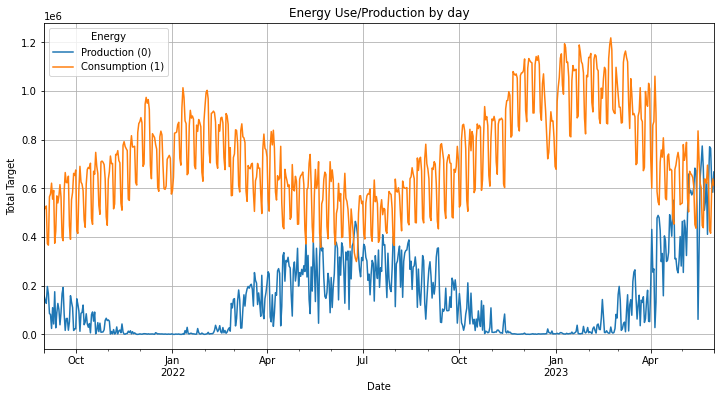

In [ ]:
energy = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()

# Pivot the data so each is_consumption value gets its own column
pivoted_energy = energy.pivot(index='date', columns='is_consumption', values='target')

# Plotting
pivoted_energy.plot(kind='line')
plt.title('Energy Use/Production by day')
plt.xlabel('Date')
plt.gcf().set_size_inches(12, 6)  # Set the figure size to make the plot larger
plt.ylabel('Total Target')
plt.legend(title='Energy', labels=['Production (0)', 'Consumption (1)'])
plt.grid(True)
plt.show()


In [46]:
pivoted_energy

is_consumption,0,1
date,,
2021-09-01,157505.391,513929.956
2021-09-02,138802.216,518908.306
2021-09-03,127900.790,527919.770
2021-09-04,197071.556,373264.397
2021-09-05,167043.915,366969.576
...,...,...
2023-05-27,771194.578,427683.894
2023-05-28,764474.043,415896.573
2023-05-29,621032.624,603023.774


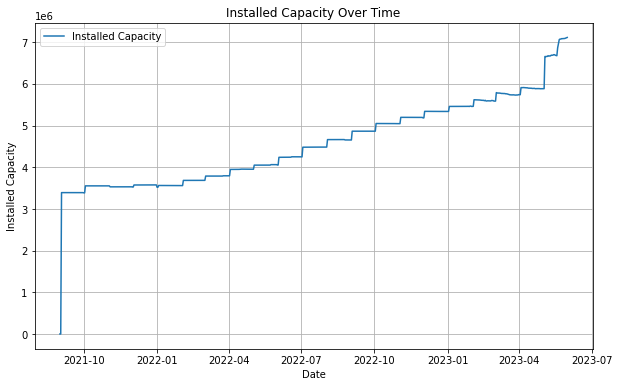

In [36]:
capacity = df.groupby(['date'])['installed_capacity_client'].sum().reset_index()
# Plotting capacity over date
plt.figure(figsize=(10, 6))
plt.plot(capacity['date'], capacity['installed_capacity_client'], label='Installed Capacity')
plt.title('Installed Capacity Over Time')
plt.xlabel('Date')
plt.ylabel('Installed Capacity')
plt.legend()
plt.grid(True)
plt.show()

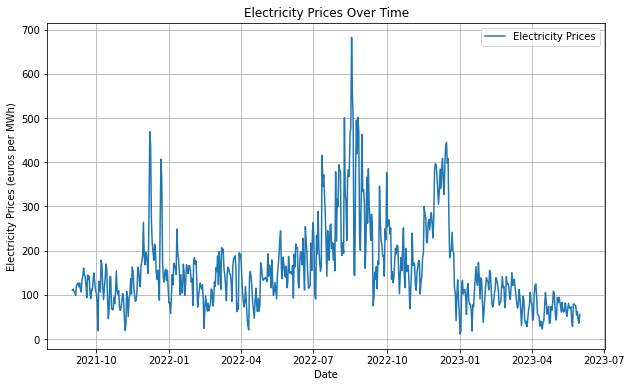

In [38]:
electricity_prices = df.groupby(['date'])['euros_per_mwh_electricity'].mean().reset_index()
# Plotting capacity over date
plt.figure(figsize=(10, 6))
plt.plot(electricity_prices['date'], electricity_prices['euros_per_mwh_electricity'], label='Electricity Prices')
plt.title('Electricity Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Prices (euros per MWh)')
plt.legend()
plt.grid(True)
plt.show()

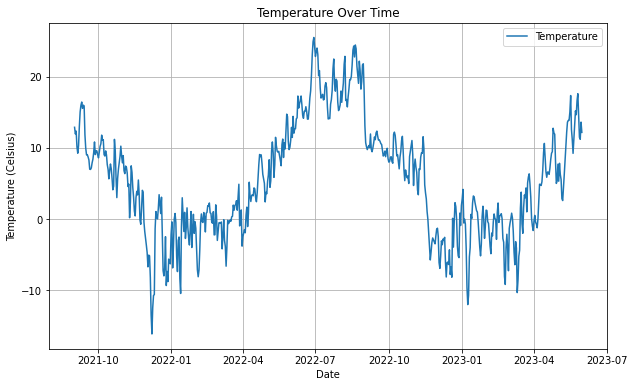

In [45]:
temp = df.groupby(['date'])['temperature_h_mean'].mean().reset_index()
# Plotting temp over date
plt.figure(figsize=(10, 6))
plt.plot(temp['date'], temp['temperature_h_mean'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
energy = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()

# Pivot the data so each is_consumption value gets its own column
pivoted_energy = energy.pivot(index='date', columns='is_consumption', values='target')

capacity = df.groupby(['date'])['installed_capacity_client'].sum().reset_index()

electricity_prices = df.groupby(['date'])['euros_per_mwh_electricity'].mean().reset_index()

temp = df.groupby(['date'])['temperature_h_mean'].mean().reset_index()

# Merge the DataFrames on the 'date' column
combined_df = pivoted_energy.reset_index()  # Reset index to include 'date' as a column
combined_df = combined_df.merge(capacity, on='date', how='left')
combined_df = combined_df.merge(electricity_prices, on='date', how='left')
combined_df = combined_df.merge(temp, on='date', how='left')

# Rename columns for clarity (optional)
combined_df.columns = ['date', 'production', 'consumption', 'installed_capacity', 'electricity_price', 'temperature']

# Display the combined DataFrame
combined_df

/var/folders/w3/ln3yv35d7tvd419758qpxvhm0000gn/T/ipykernel_22266/3175514119.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  energy = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()


,date,production,consumption,installed_capacity,electricity_price,temperature
0,2021-09-01,157505.391,513929.956,0.00,NaN,NaN
1,2021-09-02,138802.216,518908.306,0.00,110.467083,12.888391
2,2021-09-03,127900.790,527919.770,3391644.48,112.631250,11.960660
3,2021-09-04,197071.556,373264.397,3391644.48,107.429583,12.353093
4,2021-09-05,167043.915,366969.576,3391644.48,106.112917,10.134675
...,...,...,...,...,...,...
633,2023-05-27,771194.578,427683.894,7089216.24,54.062083,14.331618
634,2023-05-28,764474.043,415896.573,7090761.84,62.561667,11.490596
635,2023-05-29,621032.624,603023.774,7099401.84,44.451250,11.202870
636,2023-05-30,584241.765,638906.371,7106817.84,35.757083,13.614591
